# LangGraph `:)`

## First Things First

In [53]:
# !pip install --quiet -U langchain_openai langchain_core langchain_community tavily-python
# !pip install -qU langgraph

In [72]:
import os
import random
from pprint import pprint
from google.colab import userdata
from IPython.display import display, Image
from typing import Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage, SystemMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END

In [42]:
GIRU_OPENAI_API_KEY = userdata.get('GIRU_OPENAI_API_KEY')
GIRU_TAVILY_API_KEY = userdata.get('GIRU_TAVILY_API_KEY')
os.environ["OPENAI_API_KEY"] = GIRU_OPENAI_API_KEY
os.environ["TAVILY_API_KEY"] = GIRU_TAVILY_API_KEY

In [43]:
# checking openai llm
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
result = llm.invoke("Hi, are you deepseek?")

# printing results
print("==="*25)
print(f"RESPONSE\n{result.content}")
print("==="*25)
print("METADATA")
print(f"model: {result.response_metadata['model_name']}")
for k, v in result.response_metadata['token_usage'].items():
  print(f"{k}: {v}")

RESPONSE
No, I'm not DeepSeek. I'm an AI language model created by OpenAI. How can I assist you today?
METADATA
model: gpt-4o-mini-2024-07-18
completion_tokens: 25
prompt_tokens: 14
total_tokens: 39
completion_tokens_details: {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}
prompt_tokens_details: {'audio_tokens': 0, 'cached_tokens': 0}


In [44]:
# checking tavily tool
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("What is LangGraph?")
search_docs

# printing results
print("==="*25)
for doc in search_docs:
  for k, v in doc.items():
    print(f"{k}: {v}")
  print("==="*25)

title: Introduction to LangGraph: A Beginner's Guide - Medium
url: https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141
content: In this article, we’ll introduce LangGraph, walk you through its basic concepts, and share some insights and common points of confusion for beginners. While LangChain allows you to define chains of computation (Directed Acyclic Graphs or DAGs), LangGraph introduces the ability to add cycles, enabling more complex, agent-like behaviors where you can call an LLM in a loop, asking it what action to take next. Step 1: Define the Graph State First, we define the state structure for our graph. Step 4: Add Nodes to the Graph LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its power for their projects.
score: 0.8467682
title: LangGraph - LangChain
url: https://www.langchain.com/langgraph
content: Bu

## Session 1: Basics

 ### Simple Graph

In [48]:
# creating simple state
class State(TypedDict):
  graph_state: str

In [49]:
# functions are passed as nodes in graphs
# creating some functions/nodes

def node_a(state: State):
  print("---Node A---")
  return {"graph_state": state['graph_state'] + "Ball Thrown By A and "}

def node_b(state: State):
  print("---Node B---")
  return {"graph_state": state['graph_state'] + "Catched By B"}

def node_c(state: State):
  print("---Node C---")
  return {"graph_state": state['graph_state'] + "Catched By C"}

In [50]:
# creating simple edges kind of DAG
# creating function which will be working as a conditional edge

def decide_mood(state):
    user_input = state['graph_state']
    if random.random() < 0.5:
        return 0
    return 1

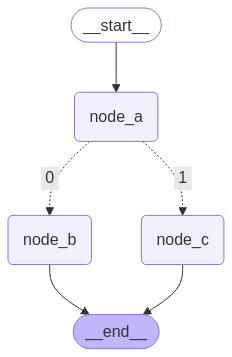

In [57]:
# first build skeleton of graph

# initialize the state
builder = StateGraph(State)

# add nodes and edges to graphs
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

builder.add_edge(START, "node_a")

builder.add_conditional_edges(
    "node_a",
    decide_mood,
    {
        0: "node_b",
        1: "node_c"
    }
)

builder.add_edge("node_b", END)
builder.add_edge("node_c", END)

# compile the skeleton
graph = builder.compile()

# view the structure of graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [70]:
result = graph.invoke({"graph_state": "In the game of Catching Balls, "})

---Node A---
---Node B---


In [71]:
print(result['graph_state'])

In the game of Catching Balls, Ball Thrown By A and Catched By B


### Use of Messages & Tools

In [73]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Bhadwa"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Bhadwa"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Bhadwa

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Bhadwa

I want to learn about the best place to see Orcas in the US.


In [74]:
# we can convert functions into custom tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [77]:
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 times 3?")])
print(tool_call.tool_calls)

[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_lraA5IDHoKQYWyHuAEwx4QEU', 'type': 'tool_call'}]


### Tool Calling Assistant